In [1]:
import numpy as np
import gym
import jax
import jax.numpy as jnp
from jax import random


from utils import experience
from value_prediction import approximator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
key = random.PRNGKey(42)

## test `Accumulator`

In [3]:
def random_transition(rng_key):
  keys = random.split(rng_key, 5)
  action = random.normal(keys[0])
  step_type = random.choice(keys[1], np.array([0,1]), (), p=np.array([0.8,0.2]))
  obsv = random.normal(keys[2], (5,))
  reward = random.normal(keys[3])
  discount = random.normal(keys[4])
  timestep = experience.TimeStep(step_type, obsv, reward, discount)
  return action, timestep

In [4]:
num_trial = 20
acc = experience.Accumulator(100,10)
for _ in range(num_trial):
  key, rng_key = random.split(key)
  acc.push(*random_transition(rng_key))

In [11]:
if acc.len_ep():
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  print(a_tm1)
  print(timesteps.obsv.shape)
  print(timesteps.reward)

[-0.5247943   1.2919614   0.17375942 -0.16435573 -0.4007549   0.8670506
  0.68050987 -0.55330265  0.8703184   1.5482894 ]
(10, 5)
[-1.0339216  -0.37174553 -0.6897025   1.2958331   0.12408566  0.94940984
 -0.36921528  0.1504747   1.0099529   0.1570648 ]


### test `Accumulator` with `gym` environment

#### Blackjack-v1

In [8]:
env = gym.make('Blackjack-v1')
env.observation_space, env.observation_space[0].n

(Tuple(Discrete(32), Discrete(11), Discrete(2)), 32)

In [9]:
acc = experience.Accumulator(100,10)
num_ep = 10

for _ in range(num_ep):
    discount = 1
    gamma = 0.9 # could be gamma*lambda*lho
    observation = env.reset()
    acc.push(None, experience.TimeStep(obsv = np.array(observation)))
    for _ in range(100):
        action = env.action_space.sample()
        # print(observation)
        observation, reward, done, info = env.step(action)
        acc.push(action, experience.TimeStep(
            int(done),
            np.array(observation),
            reward,
            discount
        ))
        discount*=gamma
        if done:
            break

In [10]:
if acc.len_ep():
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  print("actions", a_tm1)
  print("observations'", timesteps.obsv)
  print("rewards", timesteps.reward)

actions [0 0]
observations' [[13 10  0]
 [13 10  0]]
rewards [ 0. -1.]


In [6]:
appr = approximator.tabularApproximator([np.arange(sp.n) for sp in env.observation_space])

In [8]:
jax.jit(jax.vmap(appr.v))(timesteps.obsv)

DeviceArray([0., 0.], dtype=float32)

#### CartPole

In [4]:
env = gym.make('CartPole-v1')

In [5]:
acc = experience.Accumulator(max_t = 100,max_ep = 10)
num_ep = 10

for _ in range(num_ep):
    discount = 1
    gamma = 0.9 # could be gamma*lambda*lho
    observation = env.reset()
    acc.push(None, experience.TimeStep(obsv = np.array(observation)))
    for _ in range(100):
        action = env.action_space.sample()
        # print(observation)
        observation, reward, done, info = env.step(action)
        acc.push(action, experience.TimeStep(
            int(done),
            np.array(observation),
            reward,
            discount
        ))
        discount*=gamma
        if done:
            break

In [6]:
if acc.len_ep():
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  print("actions", a_tm1)
  print("observations' shape", timesteps.obsv.shape)
  print("cartpole angles", timesteps.obsv[:, 2]) # terminate when out-of-screen or |angle|> .21 rad
  print("rewards", timesteps.reward)

actions [0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1]
observations' shape (16, 4)
cartpole angles [-0.01089412 -0.0117533  -0.01853448 -0.01953659 -0.02650816 -0.0394553
 -0.04671806 -0.06007799 -0.0795783  -0.09361415 -0.1139827  -0.12911361
 -0.15076983 -0.17903107 -0.20245215 -0.22124057]
rewards [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# test `TD`

In [4]:
from value_prediction import td

In [11]:
print(td.td_zero_error(0, 1, 1, 1))
# jitted_nstep_td_errors = jax.jit(td.nstep_td_errors, static_argnums=(0,))
# print(jitted_nstep_td_errors(3, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.ones(4), .5))

print(td.nstep_td_errors(3, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.ones(4), .5))
print(td.td_lambda_errors(.5, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.zeros(4), 1))

2
[2.875 4.625]
[3.25 4.5  5.   4.  ]


In [12]:
%timeit td.nstep_td_errors(3, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.ones(4), .5)
%timeit td.td_lambda_errors(.5, jnp.zeros(4), jnp.array([1, 2, 3, 4]), jnp.zeros(4), .9)

827 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
822 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# test experiment

In [3]:
from utils import agents, experiment

## random policy tabular agent

In [4]:
env = gym.make('Blackjack-v1')
# appr = approximator.tabularApproximator([np.arange(sp.n) for sp in env.observation_space])
agent = agents.RandomAgent(env, learning_rate=0.1)
acc = experience.Accumulator(100,10)
trainer = experiment.Trainer(env, acc, './log/test_rand_blackjack/exp2')

In [9]:
train_episodes = 10000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes)

100%|███████████████| 10000/10000 [01:39<00:00, 100.28it/s]


In [10]:
v = agent.appr.table

Text(0.5, 0, 'v (no ace)')

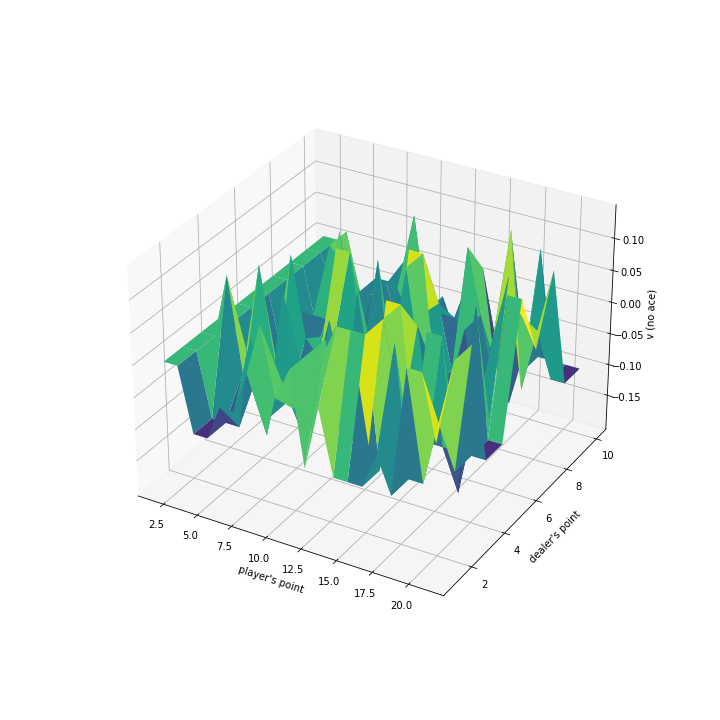

In [11]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.arange(2,22)
y = np.arange(1,v.shape[1])
X, Y = np.meshgrid(x, y) 
Z = v[X,Y,0]

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('player\'s point')
ax.set_ylabel('dealer\'s point')
ax.set_zlabel('v (no ace)')

## epsilon greedy tabular q-learning

In [4]:
env = gym.make('Blackjack-v1')
epsilon = 0.8
agent = agents.epsilonGreedyAgent(env, epsilon, learning_rate=0.1)
acc = experience.Accumulator(100,10)
trainer = experiment.Trainer(env, acc, './log/eps_q_tab_blackjack/exp1')

In [5]:
train_episodes = 1000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes)

100%|███████████████| 1000/1000 [00:29<00:00, 33.97it/s]


In [12]:
v = agent.appr.table

Text(0.5, 0, 'v (no ace)')

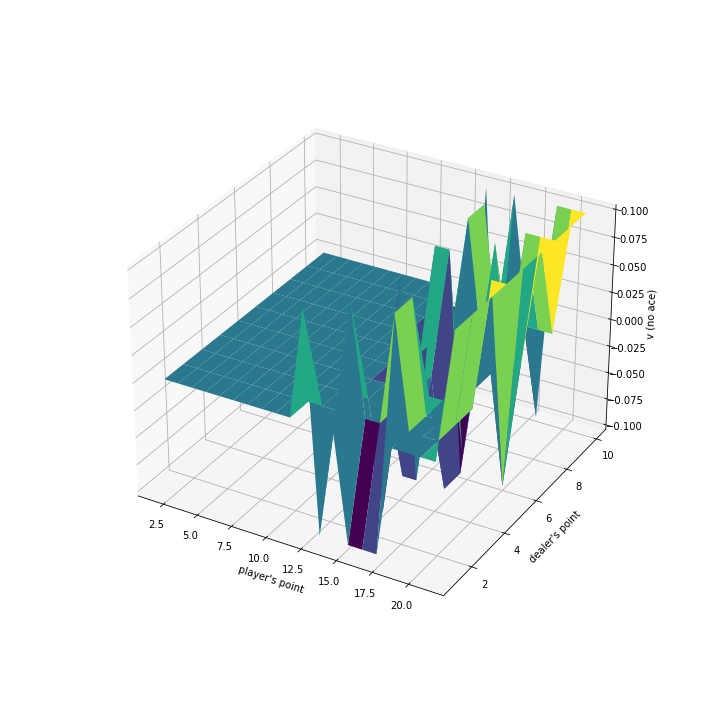

In [18]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.arange(2,22)
y = np.arange(1,v.shape[1])
X, Y = np.meshgrid(x, y) 
Z = v[X,Y,1,0]

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('player\'s point')
ax.set_ylabel('dealer\'s point')
ax.set_zlabel('v (no ace)')

In [ ]:
train_episodes = 10000
key, train_key = random.split(key)
trainer.train(train_key, agent, train_episodes)

100%|███████████████| 10000/10000 [01:39<00:00, 100.28it/s]


In [ ]:
v = agent.appr.table

Text(0.5, 0, 'v (no ace)')

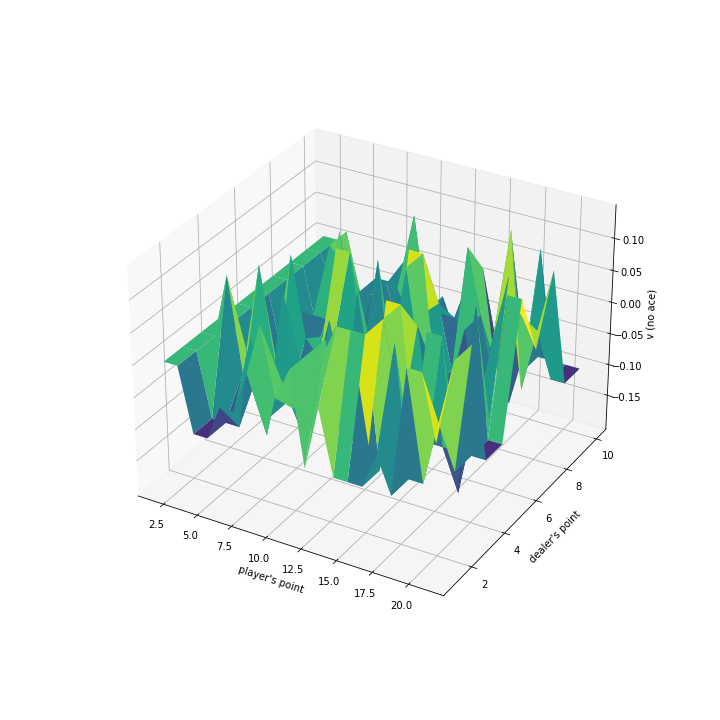

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
x = np.arange(2,22)
y = np.arange(1,v.shape[1])
X, Y = np.meshgrid(x, y) 
Z = v[X,Y,0]

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('player\'s point')
ax.set_ylabel('dealer\'s point')
ax.set_zlabel('v (no ace)')

# Random stuff

In [10]:
jnp.sum(jnp.arange(10)).item()

45

In [5]:
list(np.arange(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
len(jnp.arange(10))

10

In [7]:
# appr = approximator.tabularApproximator([jnp.arange(0,2), jnp.arange(-2,2)])
env = gym.make('Blackjack-v1')
appr = approximator.tabularApproximator([np.arange(sp.n) for sp in env.observation_space])
# appr.table

In [4]:
# states, values = jnp.array([[0,0],[0,1]]), jnp.array([2,2])
# appr.batch_update(states, values)
# appr.table

DeviceArray([[0., 0., 2., 2.],
             [0., 0., 0., 0.]], dtype=float32)

In [11]:
tmp_lst = []
for i in range(10):
  key, rng_key = random.split(key)
  ep = acc.sample_one_ep(rng_key=rng_key)
  a_tm1, timesteps = ep
  states = timesteps.obsv
  tmp_lst.append(states)
states = jnp.concatenate(tmp_lst)
states.shape

(25, 3)

In [12]:
values = random.normal(key, (states.shape[0],))
values.shape

(25,)

In [13]:
def man_bu():
  for s, v in zip(states, values):
    appr.update(s,v)

In [13]:
# %timeit man_bu()
%timeit jax.jit(appr.batch_update)(states, values)

148 µs ± 965 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
a = jnp.arange(10)
b = jnp.identity(10)
b[*list(jnp.stack((a,a), axis=1))]

SyntaxError: invalid syntax (1235250805.py, line 3)

In [43]:
jnp.stack((a,a), axis=0)

DeviceArray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int32)

In [45]:
b[tuple(jnp.stack((a,a), axis=0))]

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)